# Production Voronoi-Based Cation-Cl Cluster Analysis

This notebook implements the complete analysis pipeline for cation-Cl cluster systems using Voronoi tessellation from OVITO.

## Overview

This analysis pipeline includes:
1. Voronoi tessellation using OVITO
2. Weighted coordination analysis
3. Shared-anion network construction
4. Oligomer characterization
5. Temporal stability analysis

See `spec.md` for detailed specification.


In [1]:
# All imports
import glob
import numpy as np
import matplotlib.pyplot as plt

# OVITO imports
from ovito.io import import_file

# Local utility imports
from utils import (
    get_pipeline_info,
    extract_particle_properties,
    # Phase 2: Voronoi Tessellation
    apply_voronoi_analysis,
    extract_voronoi_bonds,
    extract_voronoi_particle_properties,
    compute_voronoi_face_areas,
    perform_voronoi_tessellation,
    # Phase 3: Weighted Coordination Analysis
    compute_weighted_coordination_analysis,
    build_coordination_histograms,
    # Phase 4: Area Thresholding and Shared Anion Graph
    build_shared_anion_graph_from_voronoi,
    assign_cluster_ids_from_graph,
    # Phase 5: Sharing Classification
    classify_cation_cation_sharing,
    compute_sharing_statistics,
    build_cation_cation_graph_with_bridges,
)

# Plotting imports
from plots import (
    setup_plot_style, 
    plot_coordination_histograms, 
    plot_weighted_coordination_comparison,
    plot_3d_cluster_component,  # Phase 4: 3D cluster visualization
    plot_unwrapped_3d_cluster_component,  # Phase 4: 3D cluster visualization with unwrapped coordinates
)


In [2]:
# %matplotlib ipympl -uncomment this line to enable interactive plotting

In [3]:
# Configure your input structure/trajectory file
input_path = '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.27/T1000K/dump.lammpstrj' # TODO: Set path, e.g., '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T900K/dump.lammpstrj'
input_path = 'yuan_take/dump.lammpstrj'
# Analysis parameters (will be used in later phases)
MIN_AREA_PERCENT = 0.1  # Minimum area threshold as percent of total
USE_RADII = False  # Whether to use atomic radii for Voronoi tessellation

cation = 'Pu'
cation = 'Ce'

print("Configuration loaded")

Configuration loaded


## Data Loading

Load trajectory file and extract basic pipeline information.


In [4]:
# Load trajectory file using OVITO
if input_path is not None:
    # Load with OVITO pipeline
    pipeline = import_file(input_path, multiple_frames=True)
    print(f"Loaded trajectory with {pipeline.source.num_frames} frames")
    
    # Choose frame index (use last frame by default)
    frame = pipeline.source.num_frames - 1
    
    # Get basic pipeline information using utils
    info = get_pipeline_info(pipeline)
    print("\nPipeline Information:")
    print(f"  Number of frames: {info['num_frames']}")
    print(f"  Number of particles: {info['num_particles']}")
    print(f"  Species: {info['species']}")
    
    # Display cell information from utils
    if info['cell_info']:
        cell_info = info['cell_info']
        print("\nCell Information:")
        if cell_info.get('matrix') is not None:
            print("  Cell matrix:")
            print(np.array(cell_info['matrix']))
        print(f"  PBC: {cell_info.get('pbc', 'N/A')}")
    
    # Set up standardized plotting style
    setup_plot_style()
    print("\nStandardized plotting style configured")
else:
    print("input_path not set. Please configure the trajectory file path above.")
    pipeline = None
    frame = None


Loaded trajectory with 25001 frames

Pipeline Information:
  Number of frames: 25001
  Number of particles: 1792
  Species: ['Cl', 'Ce', 'Na']

Cell Information:
  Cell matrix:
[[38.57406592  0.          0.         -0.27012647]
 [ 0.         38.57406592  0.         -0.27012647]
 [ 0.          0.         38.57406592 -0.27012647]]
  PBC: (True, True, True)

Standardized plotting style configured


## Basic Pipeline Info Extraction

Extract and display particle properties from a specific frame.


In [5]:
# Extract data from chosen frame
if pipeline is not None and frame is not None:
    frame_data = pipeline.compute(frame)
    properties = extract_particle_properties(frame_data)
    
    print(f"Frame {frame} Properties:")
    print(f"  Positions shape: {properties['positions'].shape if properties['positions'] is not None else 'N/A'}")
    print(f"  Species shape: {properties['species'].shape if properties['species'] is not None else 'N/A'}")
    if properties['species'] is not None:
        unique_species = np.unique(properties['species'])
        print(f"  Unique species in frame: {unique_species}")
    print(f"  Cell matrix shape: {properties['cell_matrix'].shape if properties['cell_matrix'] is not None else 'N/A'}")
    print(f"  Periodic boundary conditions: {properties['pbc']}")
else:
    print("Pipeline not loaded. Please load a trajectory file first.")

Frame 25000 Properties:
  Positions shape: (1792, 3)
  Species shape: (1792,)
  Unique species in frame: ['Ce' 'Cl' 'Na']
  Cell matrix shape: (3, 4)
  Periodic boundary conditions: (True, True, True)


## Phase 2: Voronoi Tessellation

Apply VoronoiAnalysisModifier with generate_bonds=True and extract results.


In [6]:
# Perform Voronoi tessellation

voronoi_results = perform_voronoi_tessellation(
    pipeline=pipeline,
    frame=frame,
    use_radii=USE_RADII,
    edge_threshold=0.0,
    compute_surface_mesh=False,
)

# Extract results
data = voronoi_results['data']
bonds = voronoi_results['bonds']
particle_props = voronoi_results['particle_properties']
face_areas = voronoi_results['face_areas']


In [7]:
print(face_areas)

[3.83445543 1.43457346 8.45004748 ... 0.45568457 2.55438374 0.24239139]


In [8]:
print('face_areas',len(face_areas),'bonds',len(bonds['pairs']))

face_areas 13914 bonds 13914


## Phase 3: Weighted Coordination Analysis

Compute area-weighted (CN_A) and solid-angle-weighted (CN_Ω) coordination numbers, and build coordination histograms for the cation with different neighbor types.


In [9]:
# Compute weighted coordination analysis (includes topological, area-weighted, and solid-angle-weighted)
coordination_results = compute_weighted_coordination_analysis(
    data=data,
    bonds=bonds,
    particle_properties=particle_props,
    face_areas=face_areas,
    center_species=cation
)

# Extract results
cn_topological_all = coordination_results['cn_topological_all']
cn_a_all = coordination_results['cn_a_all']
cn_omega_all = coordination_results['cn_omega_all']
histograms = coordination_results['histograms']
positions = coordination_results['positions']
species = coordination_results['species']
pairs = bonds['pairs']

print("Weighted coordination analysis completed")
print(f"  Number of {cation} atoms analyzed: {len(cn_a_all['atom_indices'])}")
print(f"\nTopological CN (all neighbors) - mean: {np.mean(cn_topological_all['cn_values']):.3f}, std: {np.std(cn_topological_all['cn_values']):.3f}")
print(f"CN_A (all neighbors) - mean: {np.mean(cn_a_all['cn_values']):.3f}, std: {np.std(cn_a_all['cn_values']):.3f}")
print(f"CN_Ω (all neighbors) - mean: {np.mean(cn_omega_all['cn_values']):.3f}, std: {np.std(cn_omega_all['cn_values']):.3f}")


Weighted coordination analysis completed
  Number of Ce atoms analyzed: 128

Topological CN (all neighbors) - mean: 11.695, std: 1.455
CN_A (all neighbors) - mean: 6.513, std: 1.552
CN_Ω (all neighbors) - mean: 5.049, std: 1.648


In [10]:
# Build histograms with different coordination types
histograms_topological = build_coordination_histograms(
    pairs, species, center_species=cation, coordination_type='topological'
)

histograms_area = build_coordination_histograms(
    pairs, species, center_species=cation, coordination_type='area',
    positions=positions, face_areas=face_areas
)

histograms_solid_angle = build_coordination_histograms(
    pairs, species, center_species=cation, coordination_type='solid_angle',
    positions=positions, face_areas=face_areas
)

print("Histograms built for all coordination types")

Histograms built for all coordination types


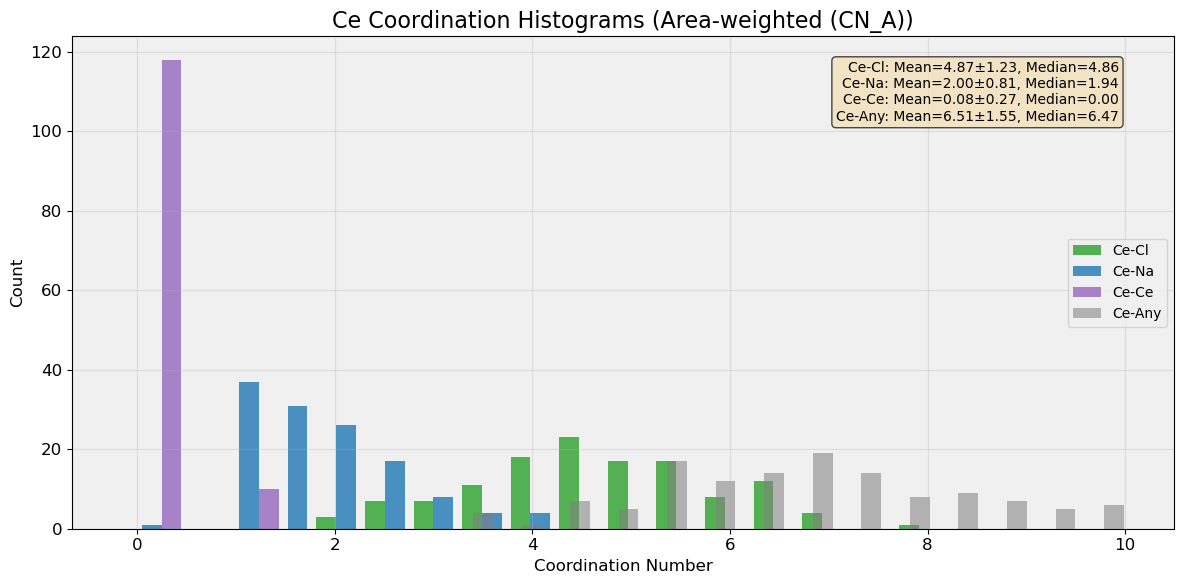

In [11]:
# Visualize coordination histograms - Topological
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_coordination_histograms(histograms_area, cation=cation, ax=ax, title=f'{cation} Coordination Histograms')
plt.tight_layout()
plt.show()


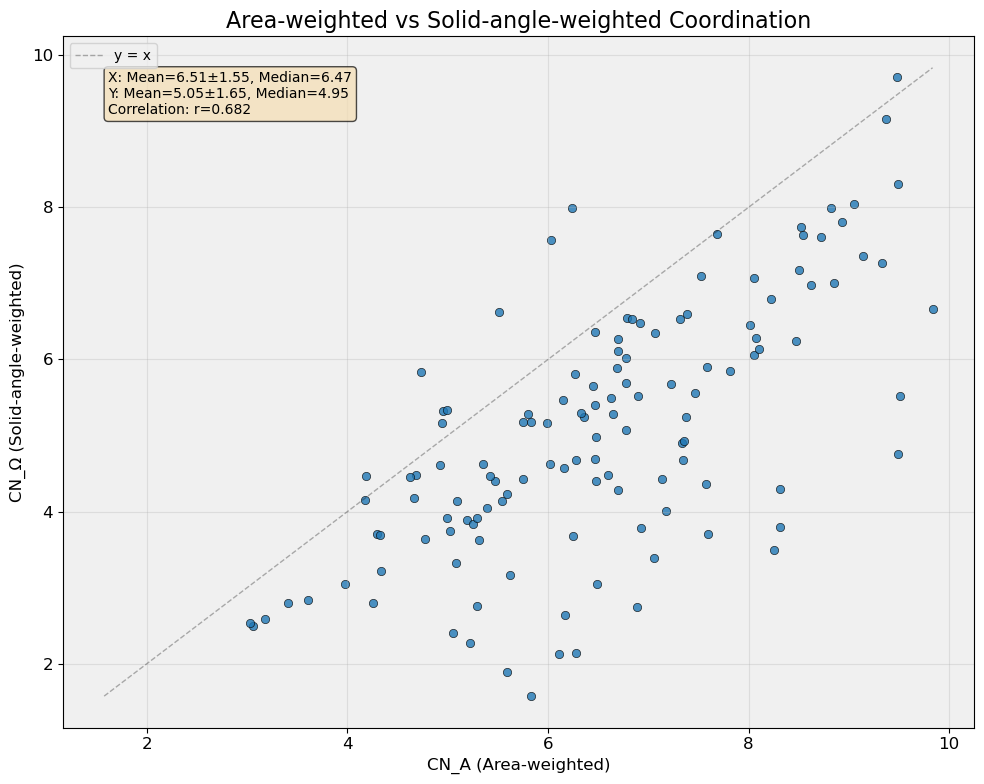

In [12]:
# Visualize CN_A vs CN_Ω comparison with statistics
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_weighted_coordination_comparison(
    cn_a_all, cn_omega_all, species, ax=ax,
    x_label='CN_A (Area-weighted)', y_label='CN_Ω (Solid-angle-weighted)',
    title='Area-weighted vs Solid-angle-weighted Coordination'
)
plt.tight_layout()
plt.show()


## Phase 4: Area Thresholding and Shared Anion Graph

Threshold Voronoi faces by area percent, build shared anion graph with cation and Cl nodes, and assign cluster IDs to connected components.


In [13]:
# Perform second Voronoi tessellation with area threshold for graph construction
# This filters faces atom-wise using OVITO's relative_face_threshold parameter
voronoi_results_filtered = perform_voronoi_tessellation(
    pipeline=pipeline,
    frame=frame,
    use_radii=USE_RADII,
    edge_threshold=0.0,
    compute_surface_mesh=False,
    relative_face_threshold=MIN_AREA_PERCENT,  # Apply threshold during tessellation
)

# Extract filtered results
filtered_bonds = voronoi_results_filtered['bonds']
filtered_pairs = filtered_bonds['pairs']  # Already filtered by OVITO
filtered_face_areas = voronoi_results_filtered['face_areas']  # Already filtered

print("Area Thresholding Results (using OVITO relative_face_threshold):")
print(f"  Original number of faces (from Phase 2): {len(pairs)}")
print(f"  Filtered number of faces (from Phase 4): {len(filtered_pairs)}")
print(f"  Faces removed: {len(pairs) - len(filtered_pairs)} ({100.0 * (len(pairs) - len(filtered_pairs)) / len(pairs):.2f}%)")
if len(filtered_pairs) > 0:
    print(f"  Average face area (original): {np.mean(face_areas):.4f}")
    print(f"  Average face area (filtered): {np.mean(filtered_face_areas):.4f}")


Area Thresholding Results (using OVITO relative_face_threshold):
  Original number of faces (from Phase 2): 13914
  Filtered number of faces (from Phase 4): 3843
  Faces removed: 10071 (72.38%)
  Average face area (original): 3.6707
  Average face area (filtered): 3.6261


In [14]:
# Compute weighted coordination analysis (includes topological, area-weighted, and solid-angle-weighted)
coordination_results_filtered = compute_weighted_coordination_analysis(
    data=data,
    bonds=filtered_bonds,
    particle_properties=particle_props,
    face_areas=filtered_face_areas,
    center_species=cation
)

# Extract results
cn_topological_all_filtered = coordination_results_filtered['cn_topological_all']
cn_a_all_filtered = coordination_results_filtered['cn_a_all']
cn_omega_all_filtered = coordination_results_filtered['cn_omega_all']
histograms_filtered = coordination_results_filtered['histograms']
positions_filtered = coordination_results_filtered['positions']
species_filtered = coordination_results_filtered['species']
pairs_filtered = filtered_bonds['pairs']

print("Weighted coordination analysis completed")
print(f"  Number of {cation} atoms analyzed: {len(cn_a_all_filtered['atom_indices'])}")
print(f"\nTopological CN (all neighbors) - mean: {np.mean(cn_topological_all_filtered['cn_values']):.3f}, std: {np.std(cn_topological_all_filtered['cn_values']):.3f}")
print(f"CN_A (all neighbors) - mean: {np.mean(cn_a_all_filtered['cn_values']):.3f}, std: {np.std(cn_a_all_filtered['cn_values']):.3f}")
print(f"CN_Ω (all neighbors) - mean: {np.mean(cn_omega_all_filtered['cn_values']):.3f}, std: {np.std(cn_omega_all_filtered['cn_values']):.3f}")


Weighted coordination analysis completed
  Number of Ce atoms analyzed: 128

Topological CN (all neighbors) - mean: 5.547, std: 0.809
CN_A (all neighbors) - mean: 3.216, std: 0.878
CN_Ω (all neighbors) - mean: 2.884, std: 0.946


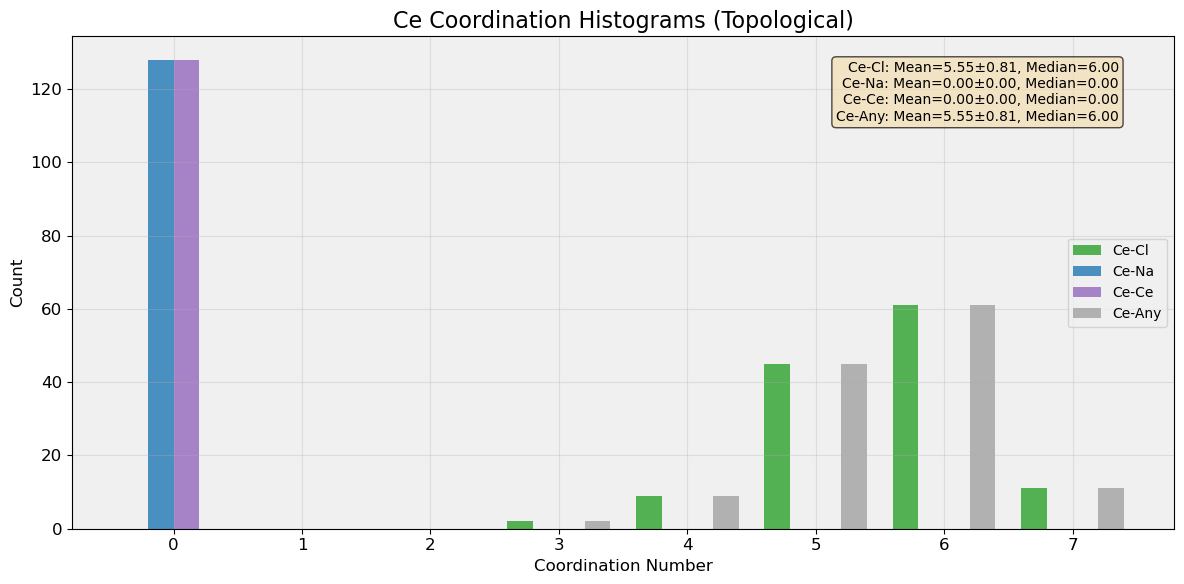

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_coordination_histograms(histograms_filtered, cation=cation, ax=ax, title=f'{cation} Coordination Histograms')
plt.tight_layout()
plt.show()

In [16]:
# Build shared anion graph from Voronoi tessellation
graph = build_shared_anion_graph_from_voronoi(
    pairs=filtered_pairs,
    face_areas=filtered_face_areas,
    positions=positions,
    species=species,
    cation=cation,
    anion='Cl',
)

print("Graph Construction Results:")
print(f"  Number of nodes: {graph.number_of_nodes()}")
print(f"  Number of edges: {graph.number_of_edges()}")

# Count nodes by species
cation_nodes = [n for n in graph.nodes() if graph.nodes[n]['species'] == cation]
cl_nodes = [n for n in graph.nodes() if graph.nodes[n]['species'] == 'Cl']
print(f"  {cation} nodes: {len(cation_nodes)}")
print(f"  Cl nodes: {len(cl_nodes)}")

# Count edges by type
cation_cation_edges = sum(1 for u, v in graph.edges() if graph.nodes[u]['species'] == cation and graph.nodes[v]['species'] == cation)
cation_cl_edges = sum(1 for u, v in graph.edges() if (graph.nodes[u]['species'] == cation and graph.nodes[v]['species'] == 'Cl') or 
                                                   (graph.nodes[u]['species'] == 'Cl' and graph.nodes[v]['species'] == cation))
cl_cl_edges = sum(1 for u, v in graph.edges() if graph.nodes[u]['species'] == 'Cl' and graph.nodes[v]['species'] == 'Cl')
print(f"  {cation}-{cation} edges: {cation_cation_edges}")
print(f"  {cation}-Cl edges: {cation_cl_edges}")
print(f"  Cl-Cl edges: {cl_cl_edges}")


Graph Construction Results:
  Number of nodes: 1152
  Number of edges: 710
  Ce nodes: 128
  Cl nodes: 1024
  Ce-Ce edges: 0
  Ce-Cl edges: 710
  Cl-Cl edges: 0


In [17]:
# Assign cluster IDs from graph
num_atoms = len(species)
cluster_ids, cluster_sizes = assign_cluster_ids_from_graph(
    graph=graph,
    num_atoms=num_atoms,
    species=species,
    cation=cation,
)

print("Cluster Assignment Results:")
print(f"  Number of clusters: {len(cluster_sizes)}")
print(f"  Total atoms in clusters: {np.sum(cluster_sizes)}")
print(f"  Unclustered atoms: {np.sum(cluster_ids == -1)}")

if len(cluster_sizes) > 0:
    print(f"\nCluster size statistics:")
    print(f"  Largest cluster size: {np.max(cluster_sizes)}")
    print(f"  Smallest cluster size: {np.min(cluster_sizes)}")
    print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
    



Cluster Assignment Results:
  Number of clusters: 79
  Total atoms in clusters: 777
  Unclustered atoms: 1015

Cluster size statistics:
  Largest cluster size: 48
  Smallest cluster size: 5
  Mean cluster size: 9.84
  Median cluster size: 7.00


Plotting cluster 0 (largest cluster)
  Cluster size: 48 atoms


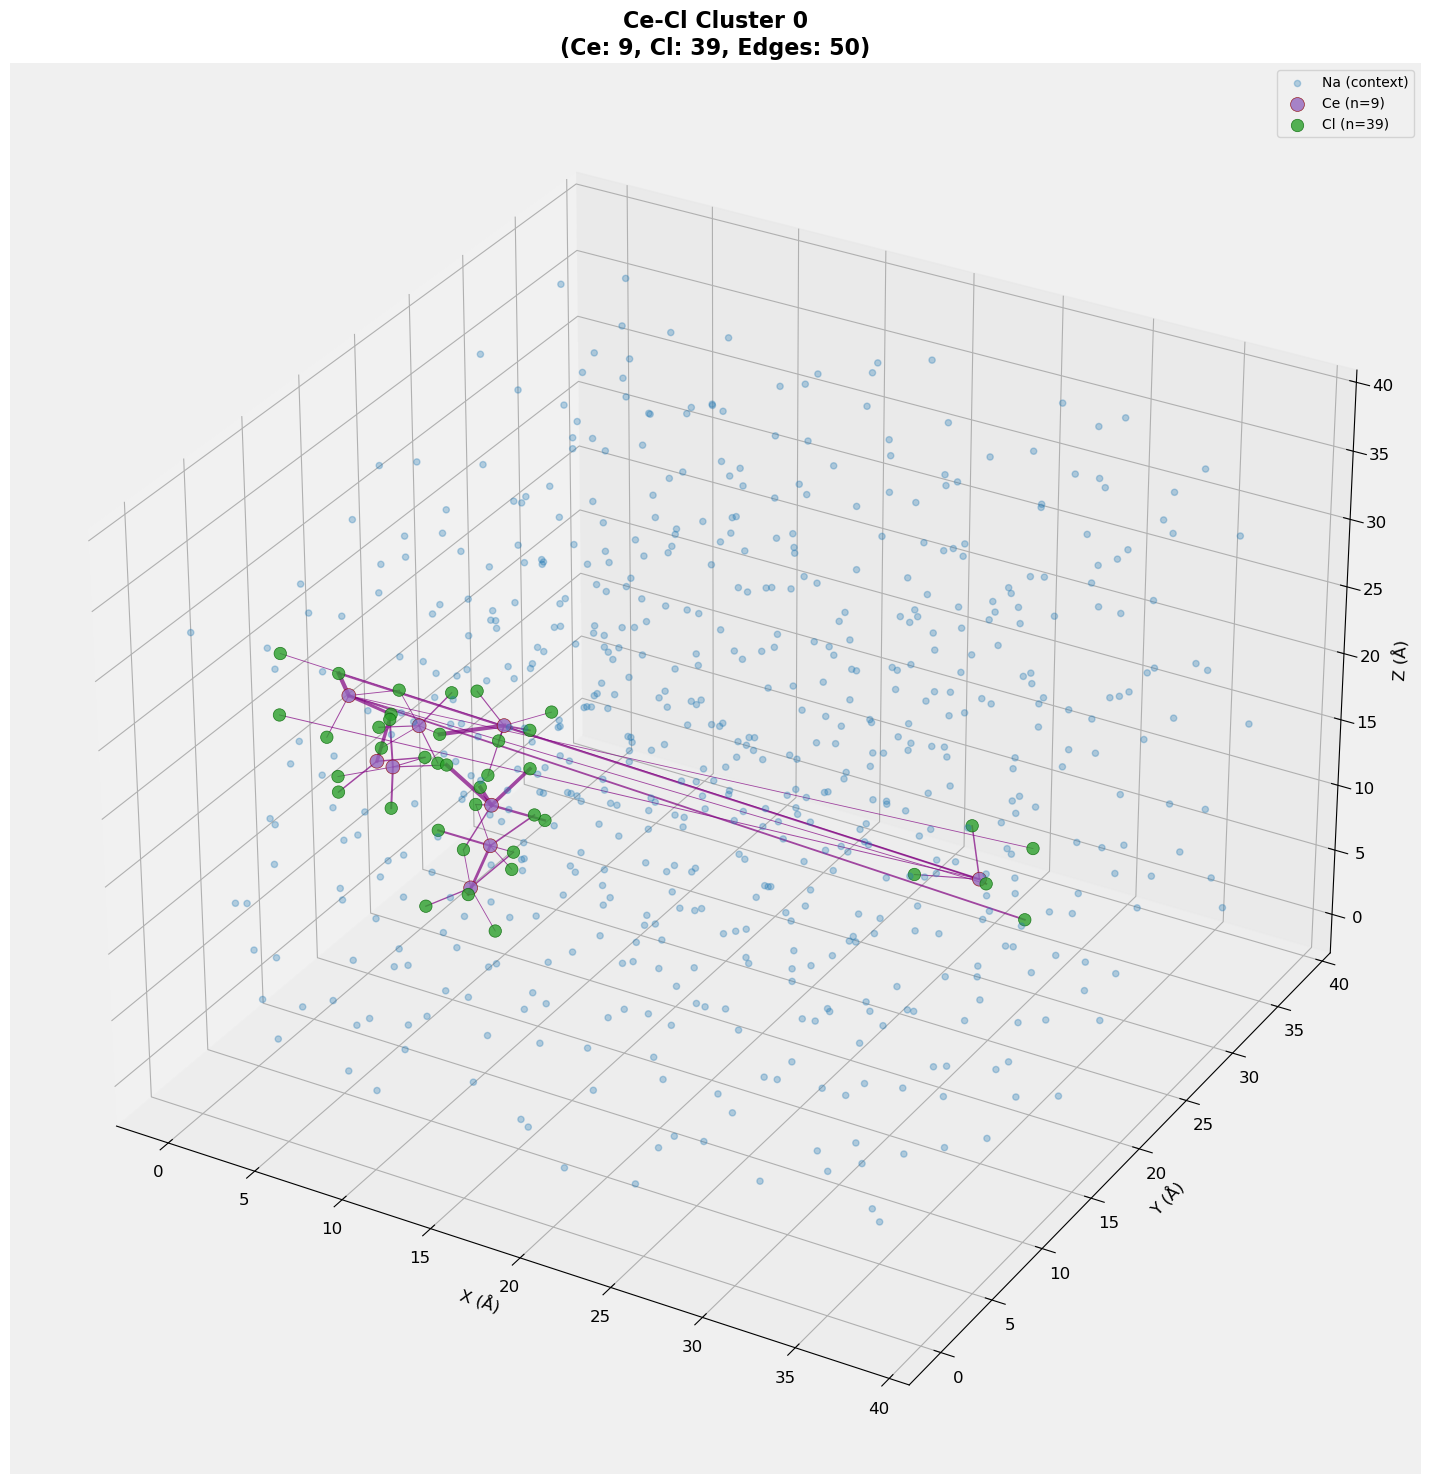

In [18]:
# Plot a specific cluster component
# Change cluster_id to visualize different clusters
# Cluster IDs range from 0 to (number_of_clusters - 1)

if len(cluster_sizes) > 0:
    # Plot the largest cluster (cluster_id = 0, since clusters are sorted by size)
    largest_cluster_id = 0
    
    print(f"Plotting cluster {largest_cluster_id} (largest cluster)")
    print(f"  Cluster size: {cluster_sizes[largest_cluster_id]} atoms")
    
    plot_3d_cluster_component(
        graph=graph,
        cluster_ids=cluster_ids,
        cluster_id=largest_cluster_id,
        positions=positions,
        species=species,
        cation=cation,
        anion='Cl',
        show_na_context=True,  # Show Na atoms as background
        show_edges=True,  # Show edges between atoms
    )
else:
    print("No clusters found to plot")


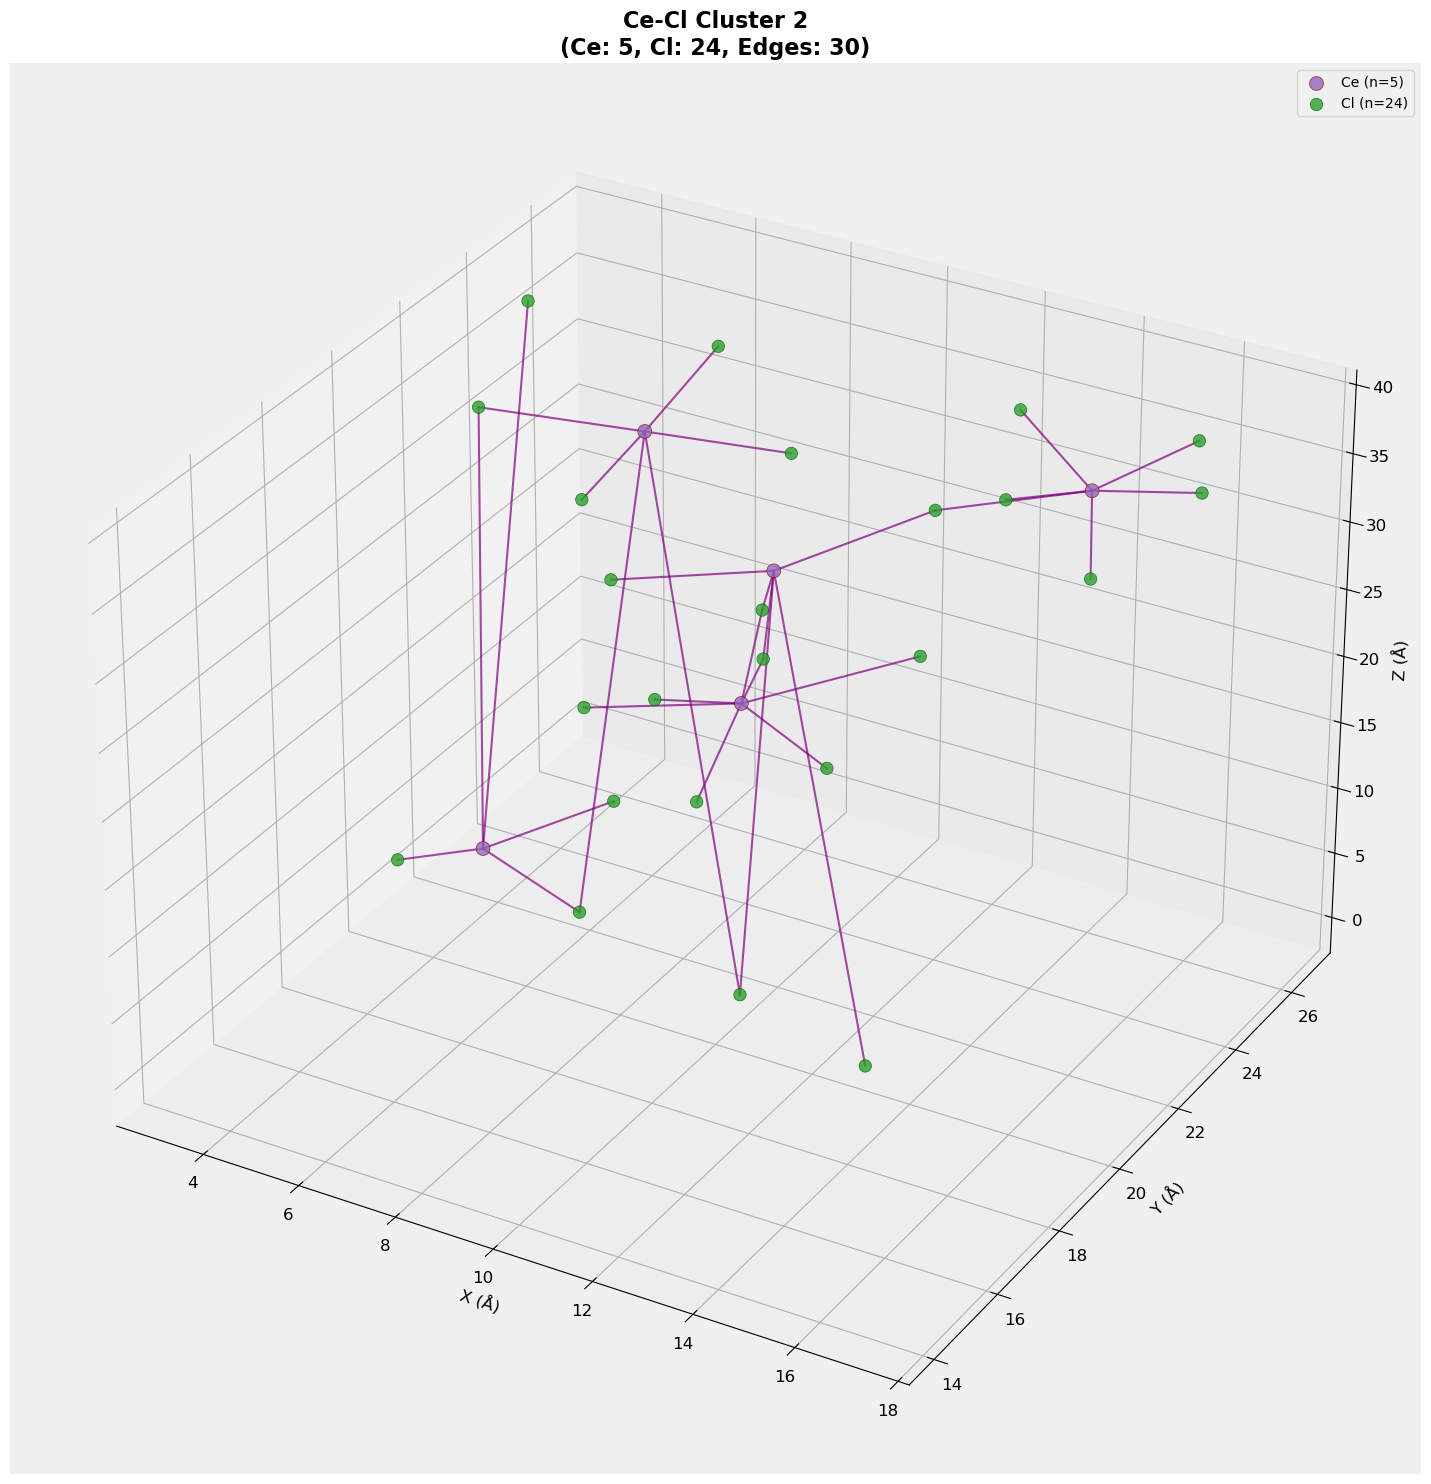

In [19]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=2,
    positions=positions,
    species=species,
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
    scale_edge_width_by_area=False,
)



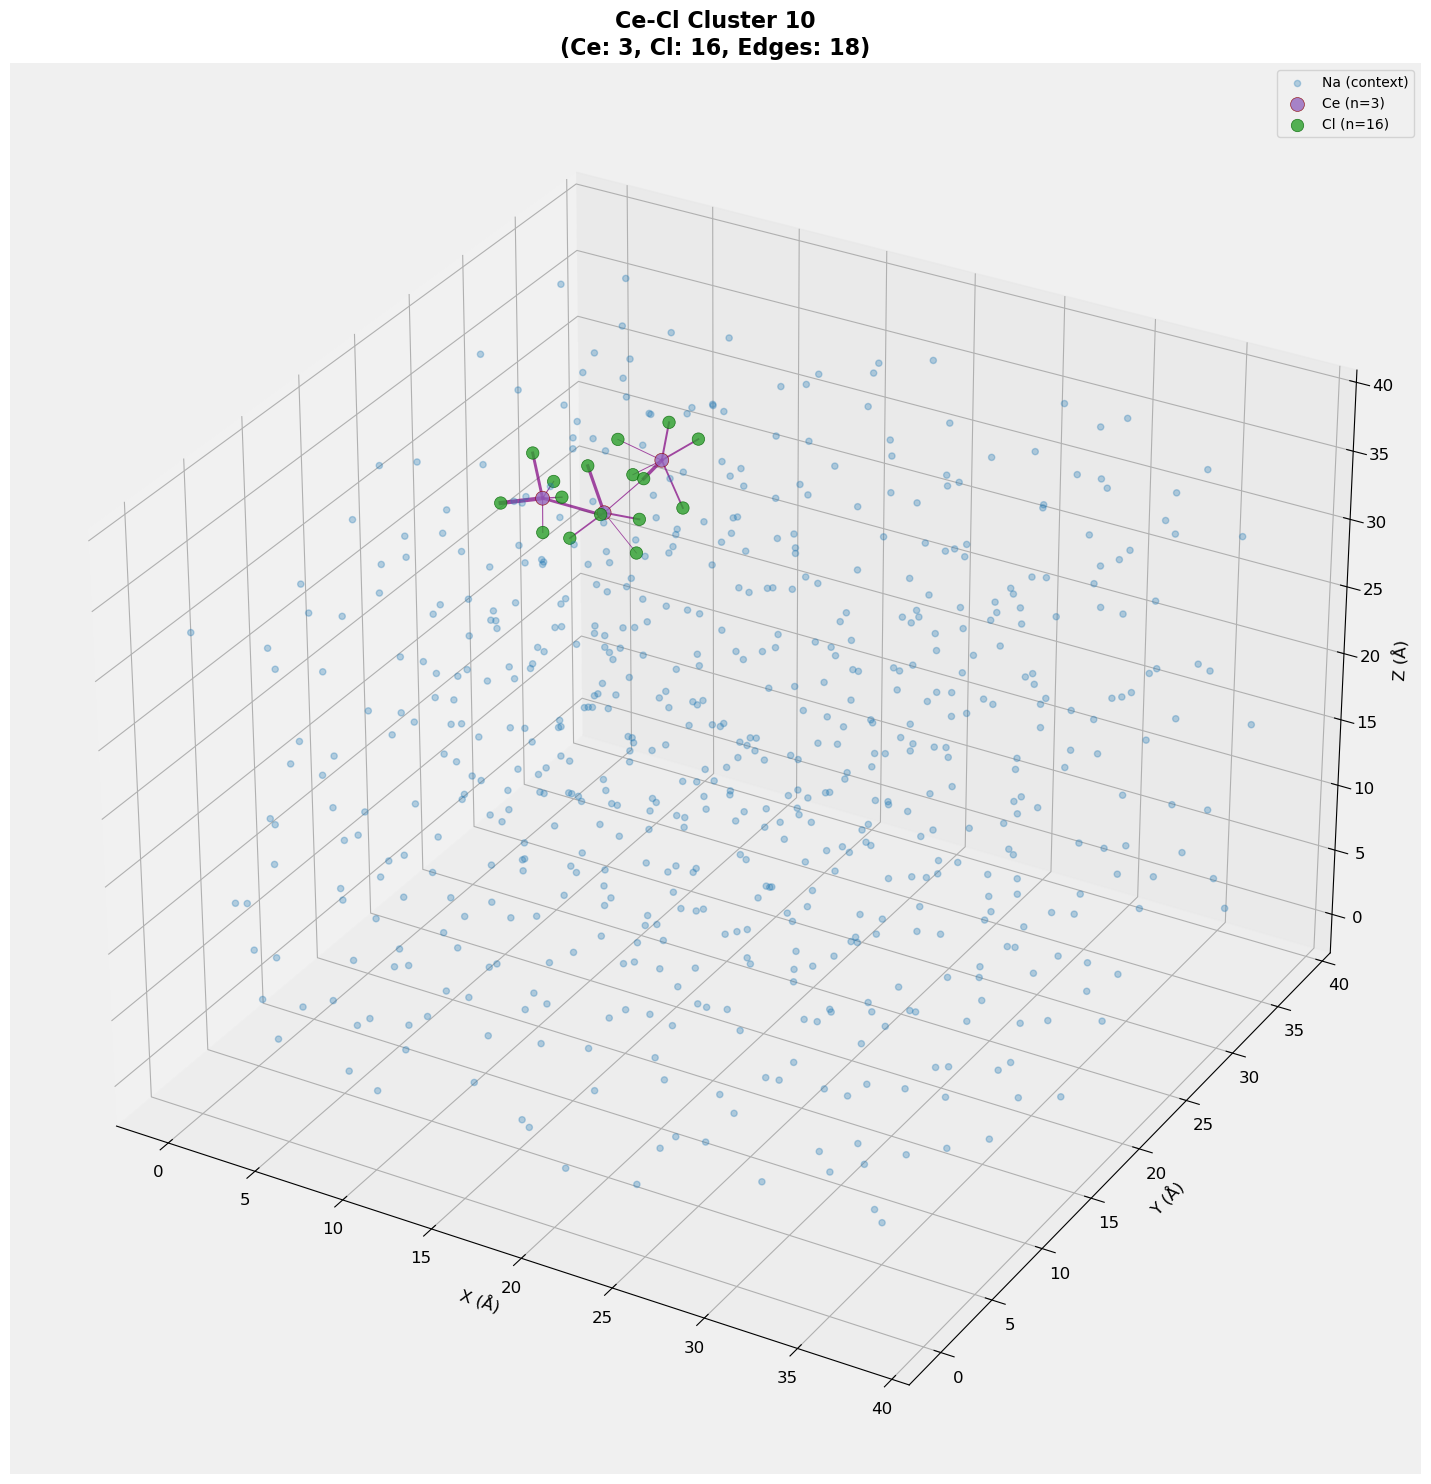

In [20]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=10,
    positions=positions,
    species=species,
    cation=cation,
    anion='Cl',
    show_na_context=True,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
)



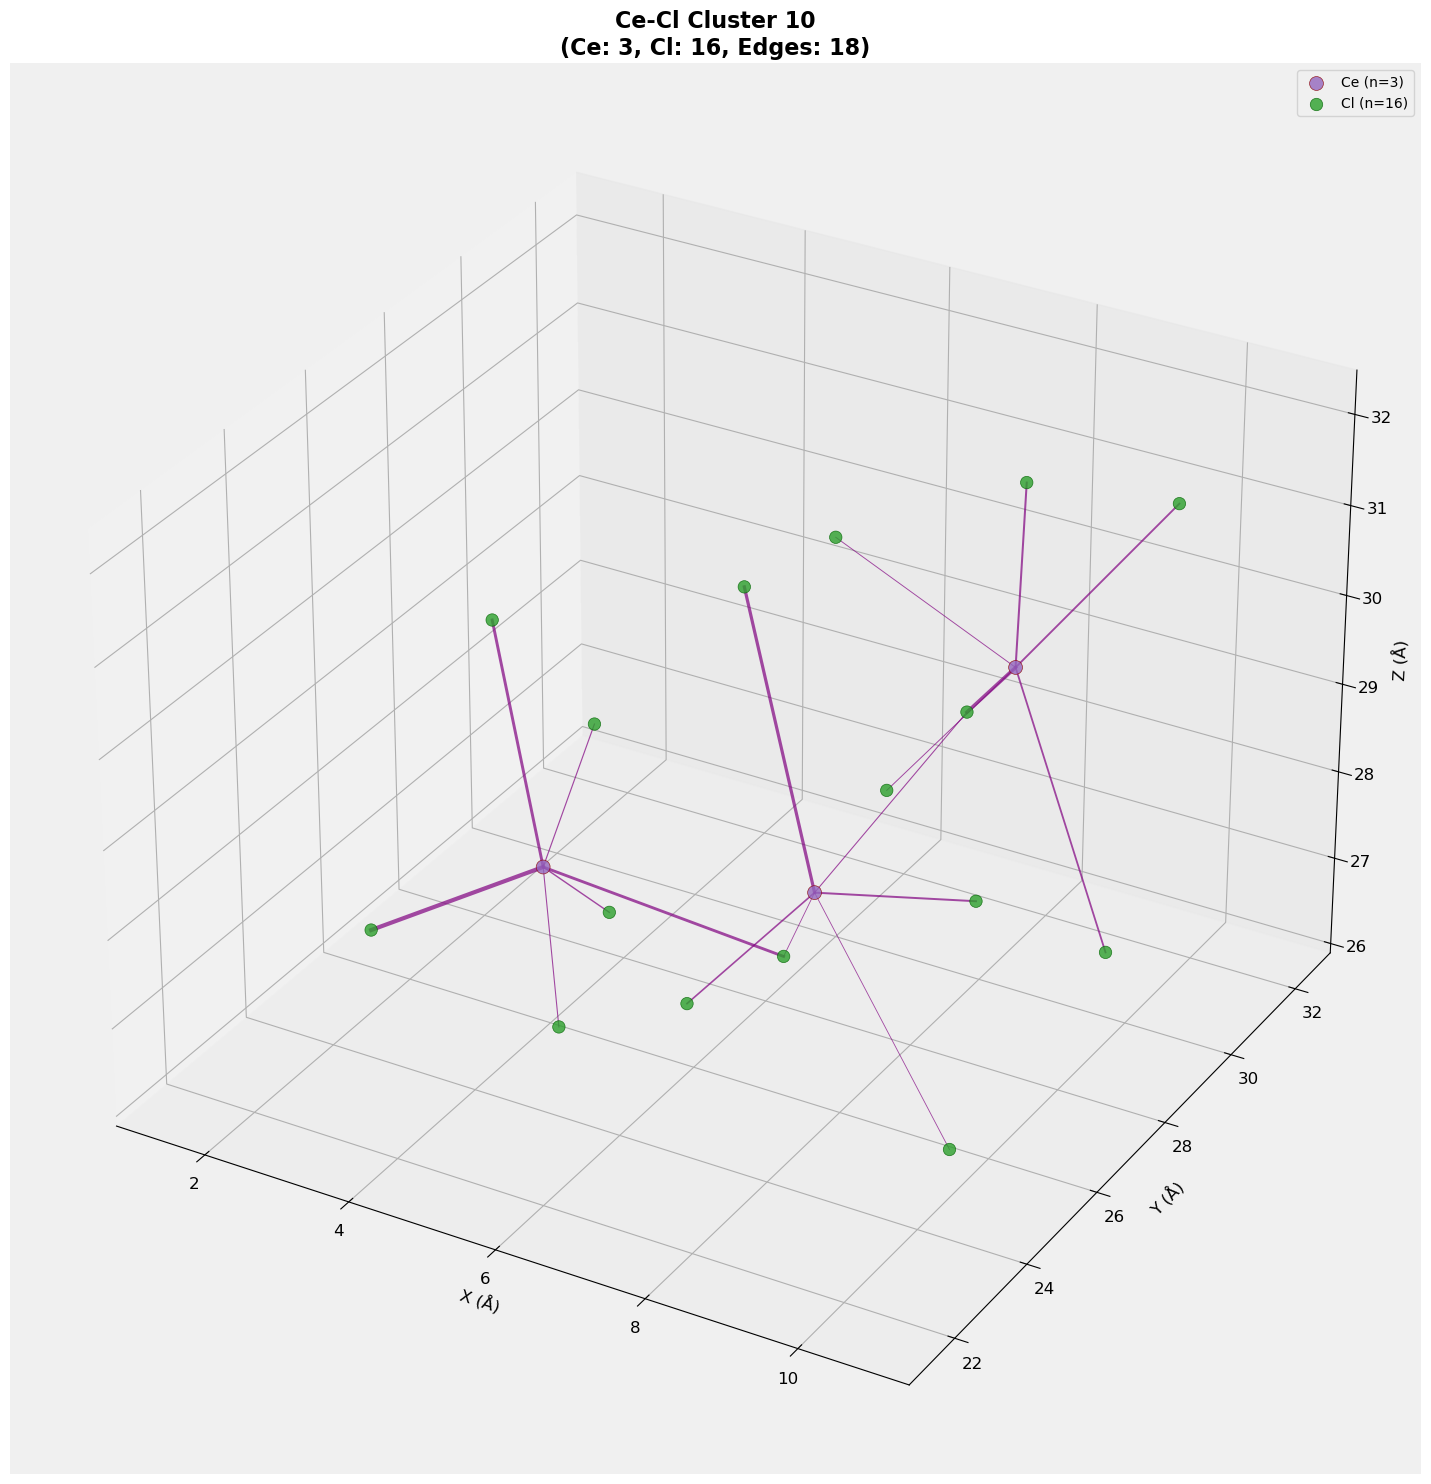

In [21]:

plot_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=10,
    positions=positions,
    species=species,
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background
    show_edges=True,  # Show edges between atoms
)



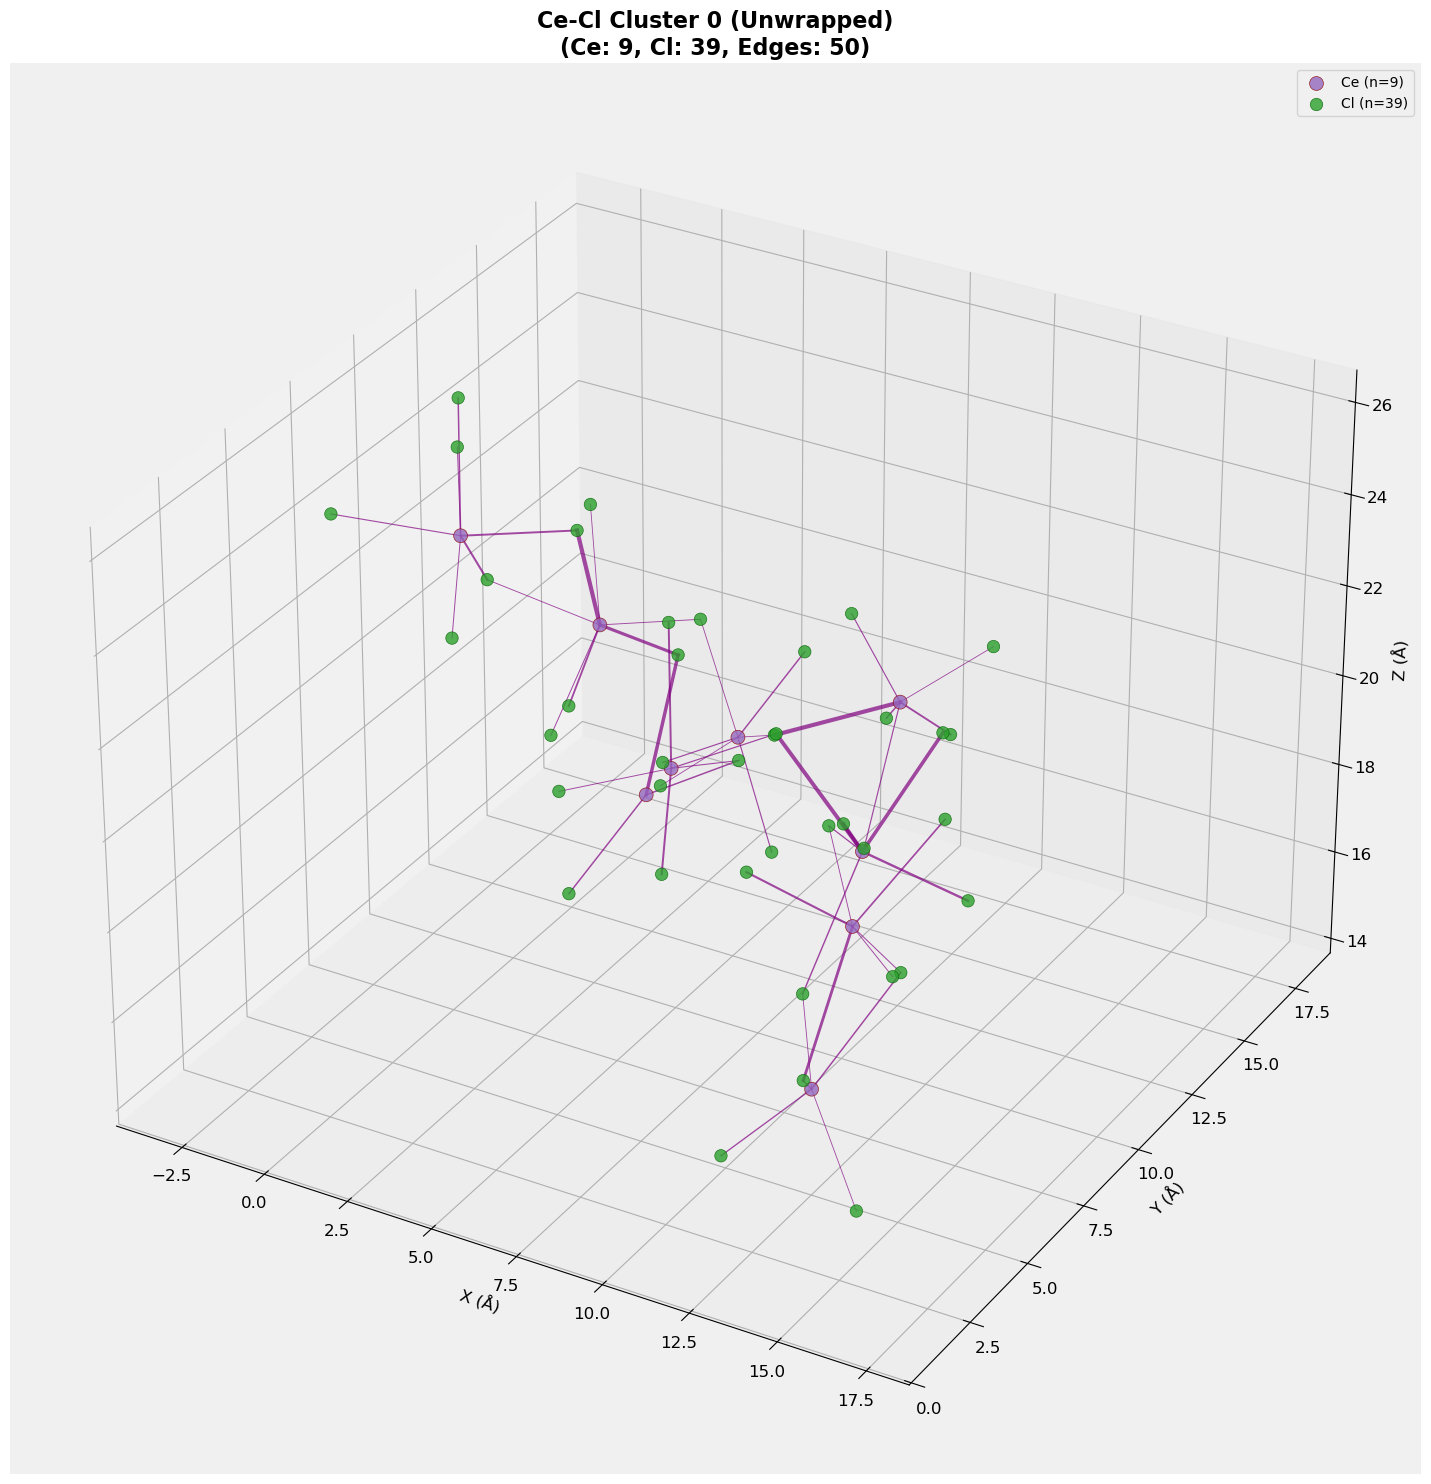

In [22]:
plot_unwrapped_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=0,
    positions=positions,
    species=species,
    cell_matrix=properties['cell_matrix'],  # Required for unwrapping
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background (wrapped coordinates)
    show_edges=True,  # Show edges between atoms (unwrapped coordinates)
)

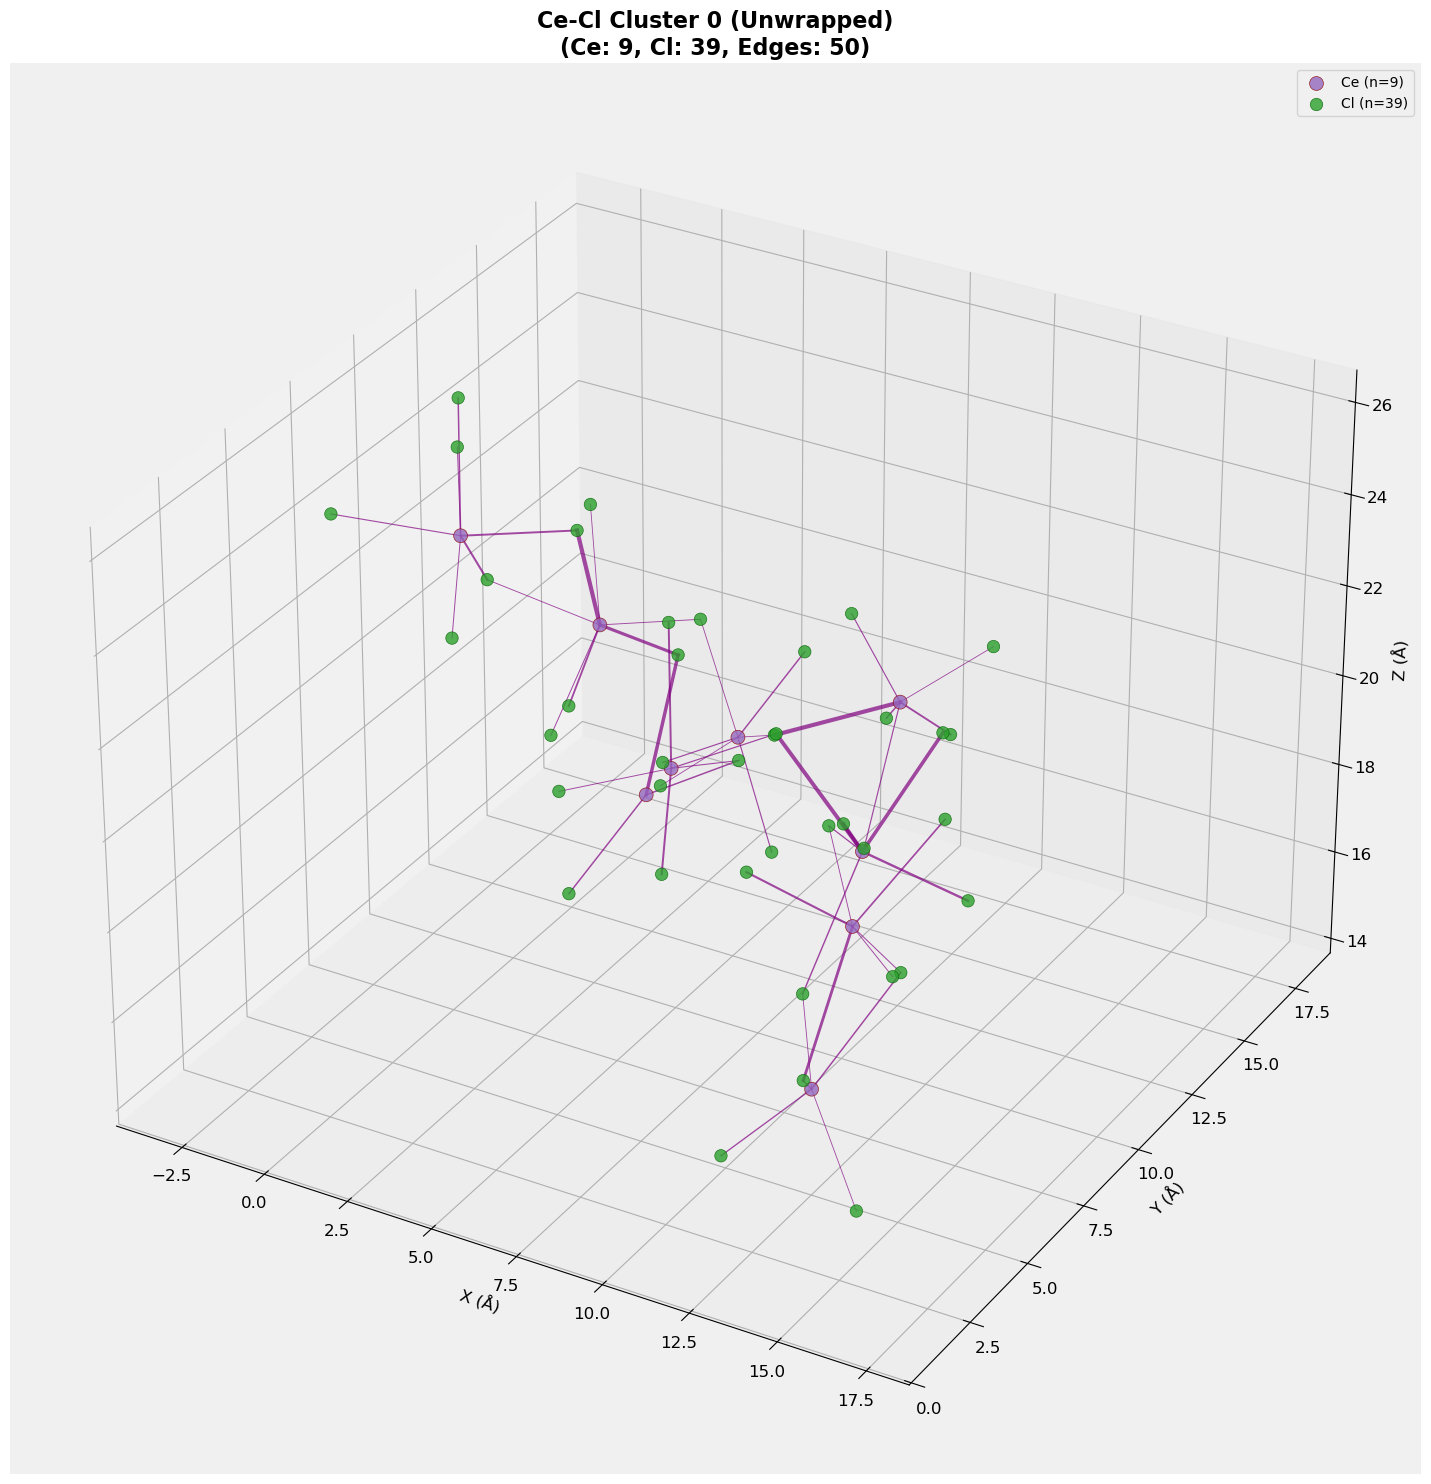

In [23]:
plot_unwrapped_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=0,
    positions=positions,
    species=species,
    cell_matrix=properties['cell_matrix'],  # Required for unwrapping
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background (wrapped coordinates)
    show_edges=True,  # Show edges between atoms (unwrapped coordinates)
)

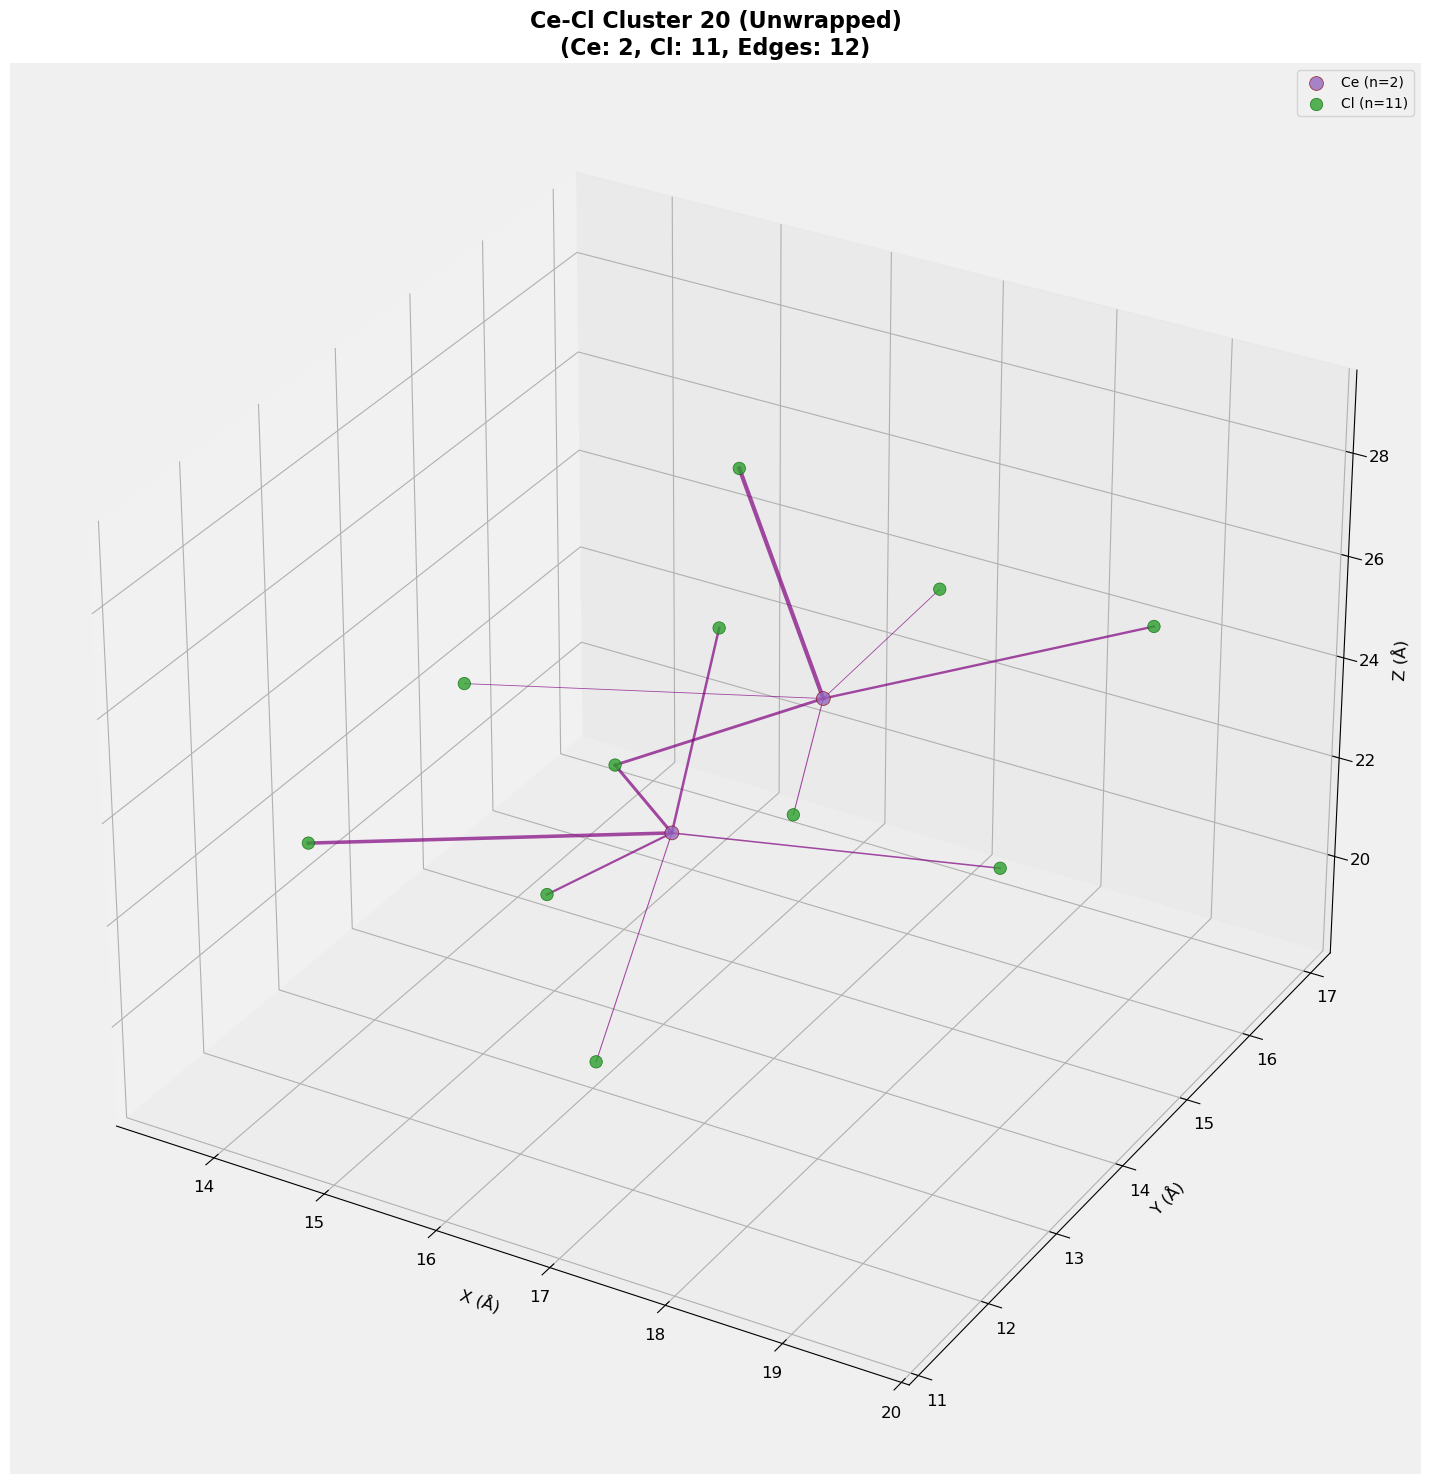

In [24]:
plot_unwrapped_3d_cluster_component(
    graph=graph,
    cluster_ids=cluster_ids,
    cluster_id=20,
    positions=positions,
    species=species,
    cell_matrix=properties['cell_matrix'],  # Required for unwrapping
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background (wrapped coordinates)
    show_edges=True,  # Show edges between atoms (unwrapped coordinates)
)

## Phase 5: Cation-Cation Sharing Classification

Classify cation-cation connections via Cl atoms as face sharing (3+ Cl), edge sharing (2 Cl), or corner sharing (1 Cl).


In [25]:
# Phase 5: Cation-Cation Sharing Classification
sharing_results = classify_cation_cation_sharing(graph, species, cluster_ids, cation=cation, anion='Cl')
stats = compute_sharing_statistics(sharing_results)

print(f"{cation}-{cation} pairs: {stats['summary']['total_pairs']} total")
print(f"  Face (3+ Cl): {stats['summary']['counts']['face']} ({stats['summary']['percentages']['face']:.1f}%)")
print(f"  Edge (2 Cl): {stats['summary']['counts']['edge']} ({stats['summary']['percentages']['edge']:.1f}%)")
print(f"  Corner (1 Cl): {stats['summary']['counts']['corner']} ({stats['summary']['percentages']['corner']:.1f}%)")

# Build cation-cation graph
graph_pu_pu = build_cation_cation_graph_with_bridges(
    graph, species, cluster_ids, positions, 
    sharing_results=sharing_results
)
print(f"\n{cation}-{cation} graph: {graph_pu_pu.number_of_nodes()} nodes, {graph_pu_pu.number_of_edges()} edges")




Ce-Ce pairs: 105 total
  Face (3+ Cl): 0 (0.0%)
  Edge (2 Cl): 11 (10.5%)
  Corner (1 Cl): 39 (37.1%)


Adding Pu-Pu edges: 100%|██████████| 79/79 [00:00<00:00, 398257.23it/s]


Ce-Ce graph: 74 nodes, 50 edges


In [26]:
# Cluster-wise sharing statistics
cluster_id = 0  # Change this to analyze different cluster

if cluster_id in stats['by_cluster']:
    cdata = stats['by_cluster'][cluster_id]
    print(f"Cluster {cluster_id}: {cdata['num_pairs']} {cation}-{cation} pairs")
    print(f"  Face (3+ Cl): {cdata['counts']['face']} ({cdata['percentages']['face']:.1f}%)")
    print(f"  Edge (2 Cl): {cdata['counts']['edge']} ({cdata['percentages']['edge']:.1f}%)")
    print(f"  Corner (1 Cl): {cdata['counts']['corner']} ({cdata['percentages']['corner']:.1f}%)")
else:
    print(f"Cluster {cluster_id} not found or has no {cation}-{cation} pairs")


Cluster 0: 36 Ce-Ce pairs
  Face (3+ Cl): 0 (0.0%)
  Edge (2 Cl): 2 (5.6%)
  Corner (1 Cl): 7 (19.4%)


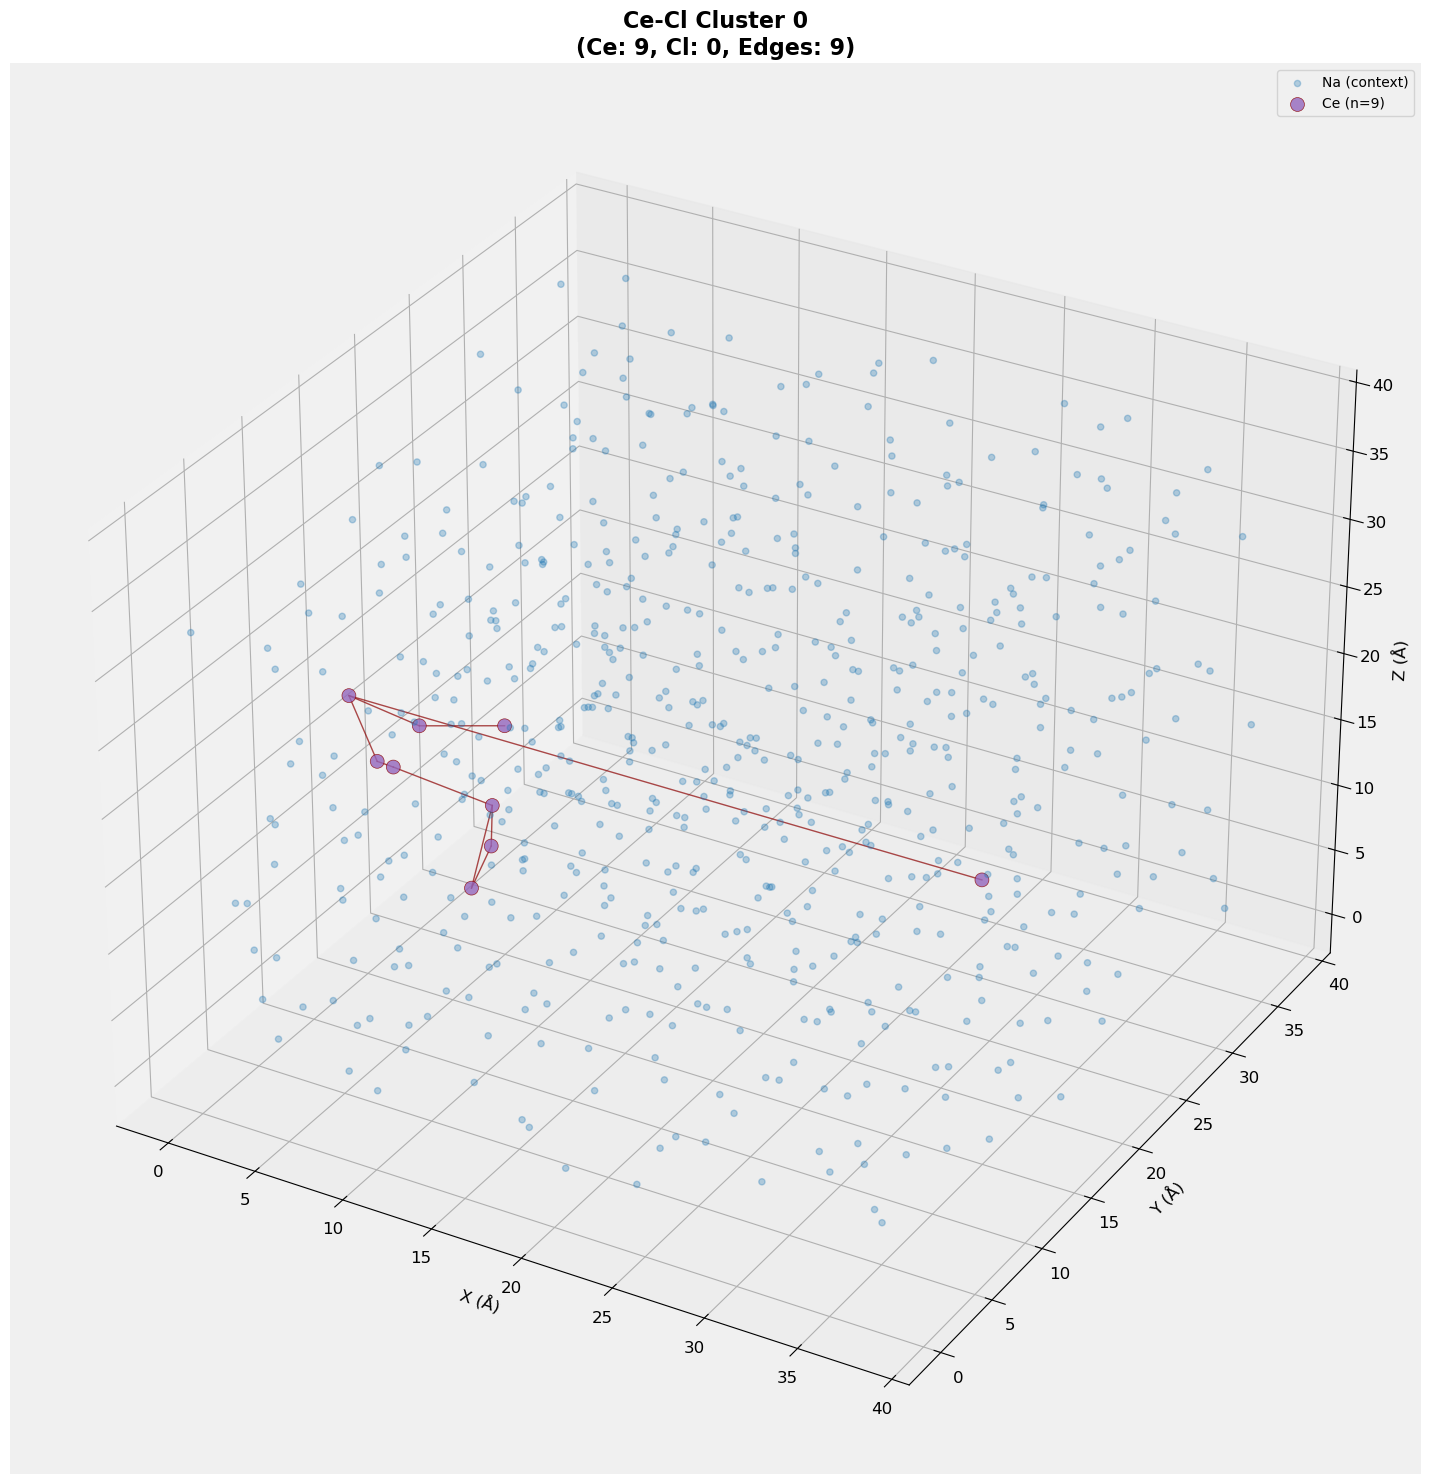

In [27]:
plot_3d_cluster_component(
    graph=graph_pu_pu,
    cluster_ids=cluster_ids,
    cluster_id=0,
    positions=positions,
    species=species,
    cation=cation,
)


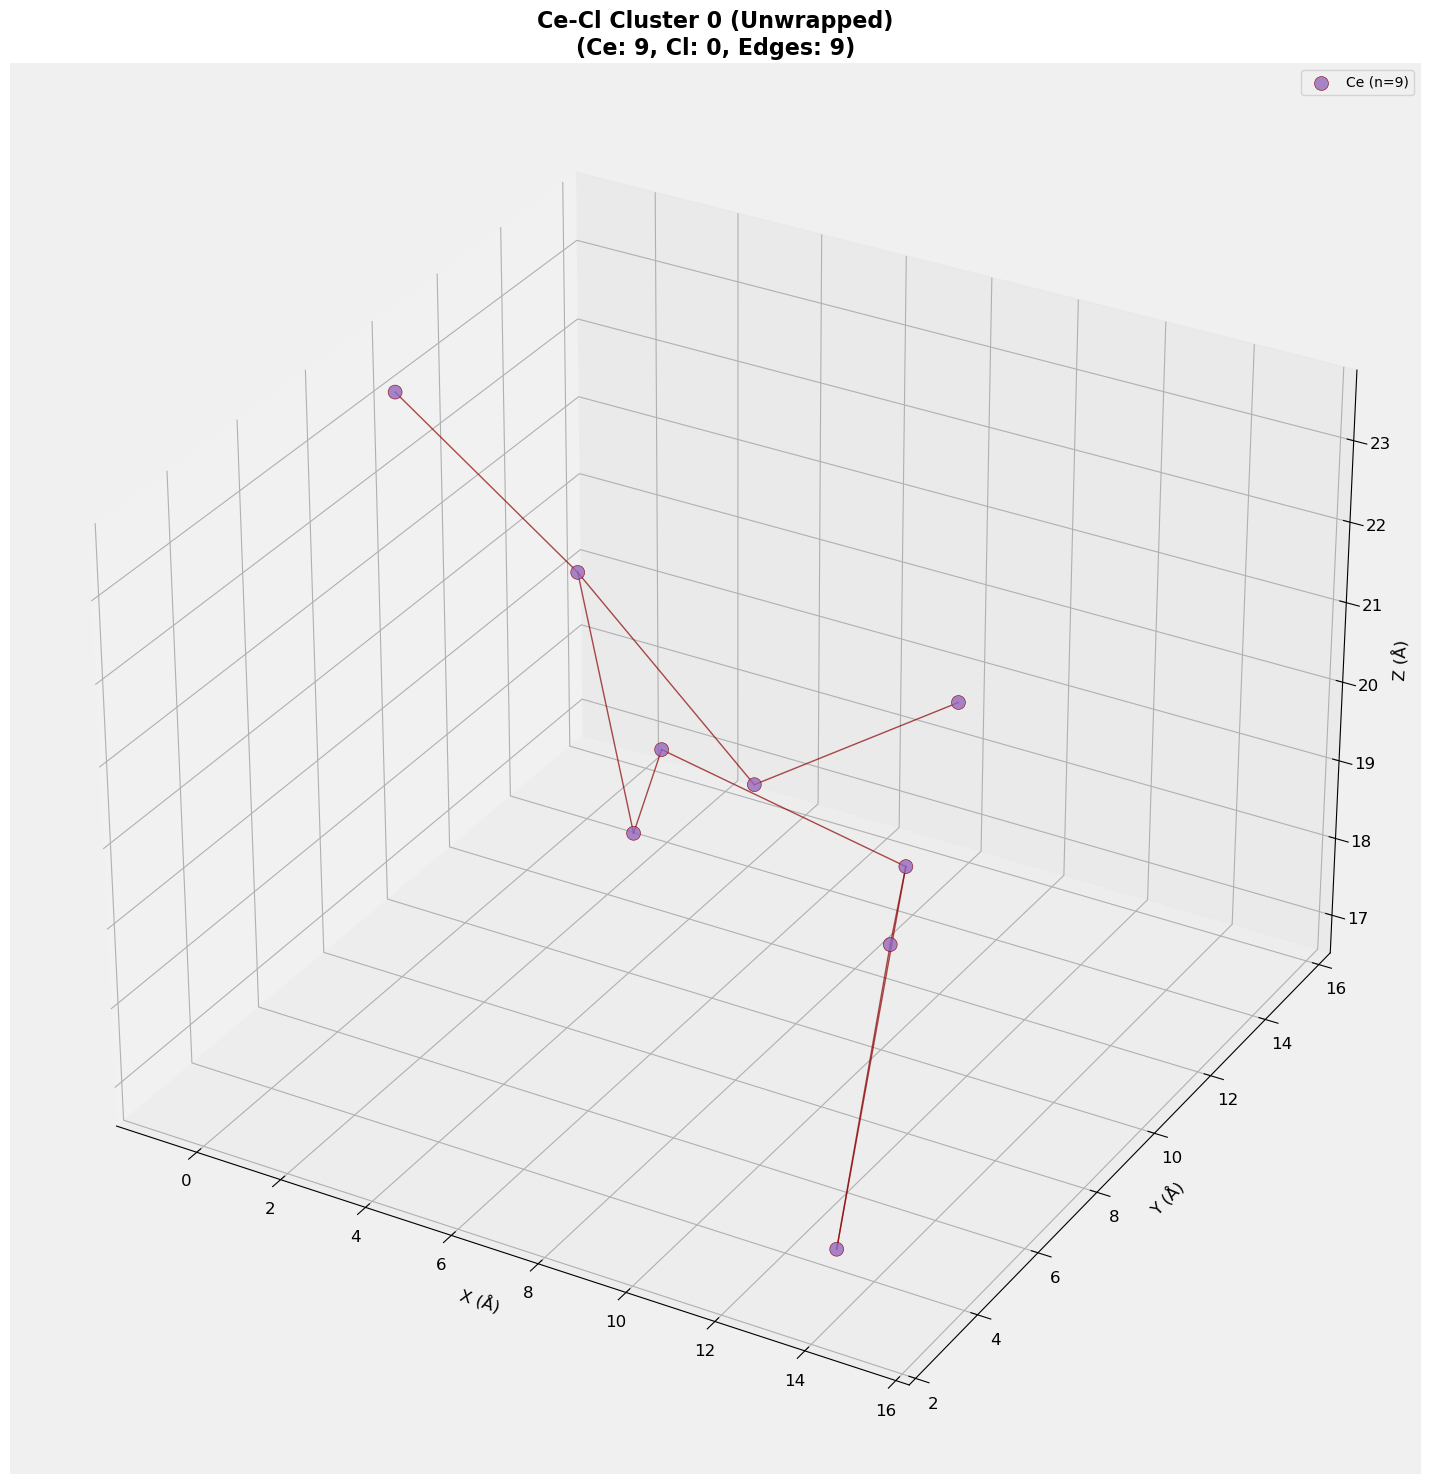

In [28]:
plot_unwrapped_3d_cluster_component(
    graph=graph_pu_pu,
    cluster_ids=cluster_ids,
    cluster_id=0,
    positions=positions,
    species=species,
    cell_matrix=properties['cell_matrix'],  # Required for unwrapping
    cation=cation,
    anion='Cl',
    show_na_context=False,  # Show Na atoms as background (wrapped coordinates)
    show_edges=True,  # Show edges between atoms (unwrapped coordinates)
)

